### PyTorch Neural Nets ###

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net()
net.to(device)


print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1drop): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2drop): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3drop): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv4drop): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (conv5drop): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1500, bias=True)
  (fc1drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1500, out_features=136, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### Transform the dataset ###

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

assert(data_transform is not None), 'Define a data_transform'

In [5]:
ruta_csvtraining = 'C:\\Users\\joker\\Desktop\\yep\\trabajo\\udacityCV\\CVND_Exercises\\PROJECT_1\\data\\training_frames_keypoints.csv'
ruta_training = 'C:\\Users\\joker\\Desktop\\yep\\trabajo\\udacityCV\\CVND_Exercises\\PROJECT_1\\data\\training\\'

ruta_csvtest = 'C:\\Users\\joker\\Desktop\\yep\\trabajo\\udacityCV\\CVND_Exercises\\PROJECT_1\\data\\test_frames_keypoints.csv'
ruta_test = 'C:\\Users\\joker\\Desktop\\yep\\trabajo\\udacityCV\\CVND_Exercises\\PROJECT_1\\data\\test\\'

In [6]:
transformed_dataset = FacialKeypointsDataset(csv_file=ruta_csvtraining,
                                            root_dir=ruta_training,
                                            transform = data_transform)
print('Number of images: ', len(transformed_dataset))

for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


### Batching and loading data ###

In [7]:
# load training data in batches
batch_size = 25

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


### Before Training ###

In [8]:
test_dataset = FacialKeypointsDataset(csv_file=ruta_csvtest,
                                            root_dir=ruta_test,
                                            transform = data_transform)

In [9]:
batch_size = 25

test_loader = DataLoader(test_dataset,
                        batch_size = batch_size,
                        shuffle = True,
                        num_workers = 0)

### Apply the model on a test sample ###

In [10]:
def net_sample_output():
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
              
        images = images.type(torch.FloatTensor)
        
        output_pts = net(images.to(device))
        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        #Break after test first image
        if i == 0:
            return images, output_pts, key_pts

In [11]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([25, 1, 224, 224])
torch.Size([25, 68, 2])
torch.Size([25, 68, 2])


### Visualize the predicted keypoints ###

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts = None):
    """Show image with predicted keypoints"""
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:,0], predicted_key_pts[:,1], s=20, marker='.', c = 'm')
    if gt_pts is not None:
        plt.scatter(gt_pts[:,0], gt_pts[:,1], s = 20, marker = '.', c = 'g')

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*112+112
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*112+112
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

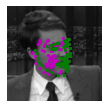

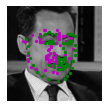

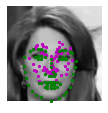

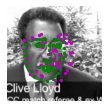

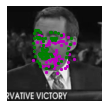

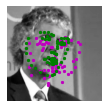

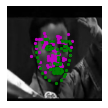

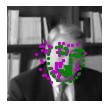

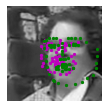

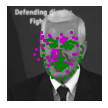

In [23]:
# call it
visualize_output(test_images, test_outputs, gt_pts)

### Training ###

In [18]:
import torch.optim as optim

#criterion = nn.L1Loss() With this one in the trainnig the loss sudennly colapses and goes really high
#criterion = nn.MSELoss()
criterion = torch.nn.SmoothL1Loss() #In the last review I was recommended to use this one.

#optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.Adam(net.parameters(), lr=0.001, betas = (0.9, 0.999), eps=1e-08)
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) # In last review they recomended me to change lr to 0.0001

In [31]:
def train_net(n_epochs):
    net.train()
    
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        total_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            
            key_pts = key_pts.view(key_pts.size(0),-1)
            
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            output_pts = net(images.to(device))
            #output_pts = net(images)
            
            loss = criterion(output_pts.to(device), key_pts.to(device))            # calculate the loss between predicted and target keypoints
            optimizer.zero_grad()                                                  # Zero the parameter (weight) gradients
            loss.backward()                                                        # Backward pass to calculate the weight gradients
            optimizer.step()                                                       # Update the weights
            
            #print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:  
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch+1, batch_i+1, running_loss/10))
                total_loss += running_loss/10
                running_loss = 0.0
        total_loss += running_loss/(batch_i % 10 + 1)
        print(total_loss)
    print('Finished training')
            

In [38]:
n_epochs = 20

#with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.005621453584171832
Epoch: 1, Batch: 20, Avg. Loss: 0.004925671918317676
Epoch: 1, Batch: 30, Avg. Loss: 0.006200724048539996
Epoch: 1, Batch: 40, Avg. Loss: 0.006793512497097254
Epoch: 1, Batch: 50, Avg. Loss: 0.0063593569211661816
Epoch: 1, Batch: 60, Avg. Loss: 0.006763091776520014
Epoch: 1, Batch: 70, Avg. Loss: 0.005572545644827187
Epoch: 1, Batch: 80, Avg. Loss: 0.005502190347760916
Epoch: 1, Batch: 90, Avg. Loss: 0.009036294603720307
Epoch: 1, Batch: 100, Avg. Loss: 0.00646520450245589
Epoch: 1, Batch: 110, Avg. Loss: 0.006178728048689663
Epoch: 1, Batch: 120, Avg. Loss: 0.005124334339052438
Epoch: 1, Batch: 130, Avg. Loss: 0.005488601583056152
0.08573960493991357
Epoch: 2, Batch: 10, Avg. Loss: 0.006943075894378125
Epoch: 2, Batch: 20, Avg. Loss: 0.006423793779686093
Epoch: 2, Batch: 30, Avg. Loss: 0.006477731722407043
Epoch: 2, Batch: 40, Avg. Loss: 0.004880476649850607
Epoch: 2, Batch: 50, Avg. Loss: 0.00426176474429667
Epoch: 2, Batch: 60, Av

### Test Data ###

In [41]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([25, 1, 224, 224])
torch.Size([25, 68, 2])
torch.Size([25, 68, 2])


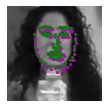

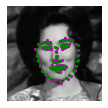

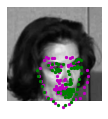

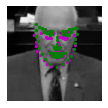

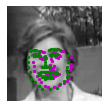

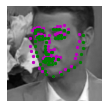

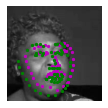

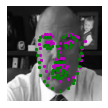

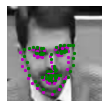

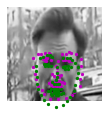

In [42]:
visualize_output(test_images, test_outputs, gt_pts)

In [45]:
## TODO: change the name to something uniqe for each new model
model_dir = 'C:\\Users\\joker\\Desktop\\yep\\trabajo\\udacityCV\\CVND_Exercises\\PROJECT_1\\saved_models\\'
model_name = 'keypoints_model_5_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)
#net.load_state_dict(torch.load(model_dir+model_name))

### Question 1: What optimization and loss functions did you choose and why?

**Answer**: Since it is a problem of coordinate points and not classification, I used MSELoss and Adam, which is the recomended for this kind of problems. I have also tried SGD and others loss functions, but they didn't drastically improved the training so I eventualy came back to MSELoss and Adam, which gave me the best results.

After the first review I was told to try SmoothL1 Loss, and indeed it improved a lot the model, along with the change of the learning rate in the Adam optimization, from 0.001 to 0.0001. Also I added a total_loss variable to check the loss in each epoch, and I checked that it decreased regularly.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: First I started with 4 convolutional networks with dropdowns, and two linear layers. It was too much, so I reduced it to 3 convolutional and 1 linear layers. 

Now I am having issues with faces which aren't in the center of the image, it is like if the net learnt that the faces are in the center. Next round I am going to increase the images per batch ( I did already from 10 to 20 and it improved a lot) and I am going to make a better random crop, because I think I should train the network with parcial faces.

It was a complete disaster, I will play a bit more with corp size and batch size until move to other things.

Nothing seems to work. I have tried with an extra convolutional layer, changing drops, batches and epochs. It always just learn to distribute the points in the center of the image forming a common face.

I have discover that if I use relu, it ends up drawing a standard face in the middle of the image, no matter if the face is in the center or a corner. But when I use elu at least it try to adapt to where the face it, although I am not making much progress. I will try to get better results with elu. I have upgraded my net and now it uses 4 convolutional layers and 3 dense layers.

Finally I got an acceptable result. I was experimenting with my net, eliminated one dense layer (only 2 left) and after training 10 epochs with 15 batches I got a promising result, with the points realocating near the face, no matter if it is in the center or a side/corner. After 10+10+10 epochs The result is quite good, with loss still going down. In the last 10 epochs it reached for the first time a value behind 0.02, and ended up with values between 0.025 and 0.015. 

I have tried to get a result better than this and I couldn't, though I obtained similar ones. The only problem now is that sometimes the loss explodes like a volcano and the net parameters become a complete disaster. It is rare though, I obtained consistent results after 50 epochs, this 'explosion' only happened two or three times out of ten. The rest cases ended up with similar values and results as the first.

Finally, another model which is giving me good results is 5 conv layers (just added one in the end, 2 2x2 filters) and in the first dense layer the outputs are incremented from 1000 to 1500.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I tried with 10,20,30 and 50 batch_size, and my conclusion is that 20-30 is the best number, at least for this specific problem.
I usually start with one epoch, and then continue with 2 epochs at a time, and see how the net develops.

In the end, with my first 'acceptable' model I used 15 as batch size (started with 10 but incremented to 15) and 10 epochs. After watching the result, train again other 10 epochs until I see the loss is not decrementing anymore. 

I obtained similar results training with 20 and 25 batch size, also the 'volcano explosion' described in the question before seems to be related to small batch sizes, thats why I changed my batch to 20 and 25 and obtained similar results.

### EXTRA

**Answer**: I discovered a 'bug' in your notebooks which gave me a good headache, by the way.  We are supposed to convert pixel's values from 0 - 255 to 0 - 1. Thing is, when we read the image from data with the line:
    image = mpimg.imread(image_name)
inside data_load, it already converts the image to a 0-1 pixel values. After that, in the normalization section in data_load again it divides by 255, so in the end you get values from 0.001 to 0.01 aprox. 
I noticed it because in notebook 3 I was reading the images with cv2.imread, which doesn't apply the 0-1 conversion, so my network didn't behaved as expected. After a lot of hours of headache I found the problem and solved by simply reading in data_load with cv2 and retrained my nets.

### Feature visualization ###

[[ 0.14417668 -0.10935236  0.09050826  0.0484827   0.12229974]
 [ 0.10748138 -0.06630864  0.05134761  0.15394755 -0.03633179]
 [ 0.02862419 -0.13770536 -0.15281895 -0.13687474 -0.03051388]
 [-0.14520822 -0.07417964 -0.11951004 -0.05188687 -0.00427473]
 [ 0.19740656 -0.03977853 -0.11705533  0.04439283  0.07413502]]
(5, 5)


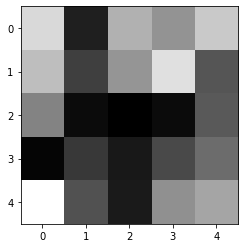

In [43]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 6

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


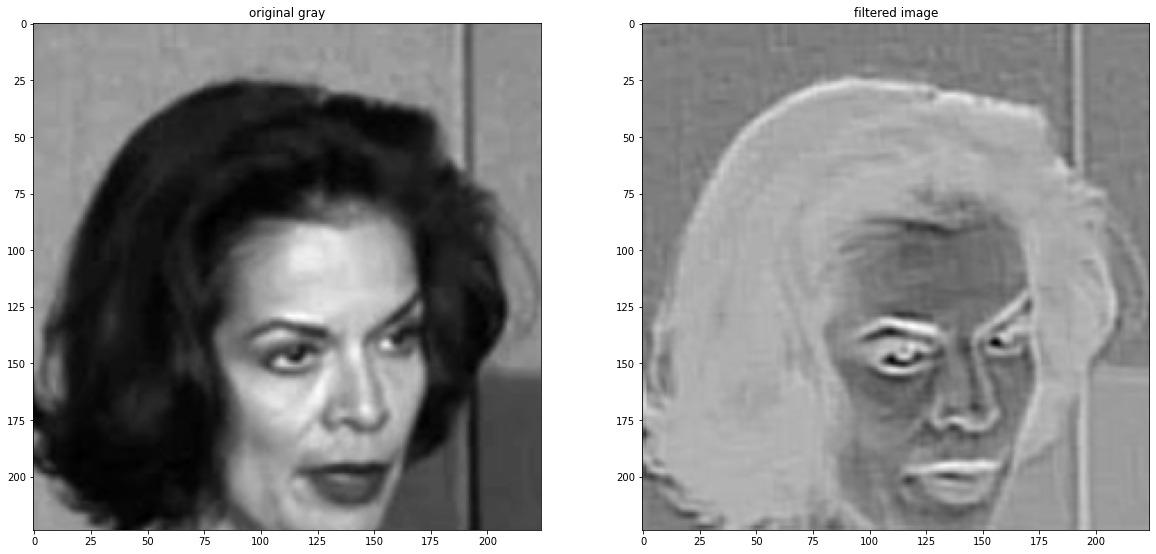

In [44]:
import cv2

##TODO: load in and display any image from the transformed test dataset
image = test_images[2].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('original gray')
ax1.imshow(image, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

# image_filtered = cv2.filter2D(gray_blur, -1, sobel_y)
image_filtered = cv2.filter2D(image, -1, w[filter_index][0])

ax2.set_title('filtered image')
ax2.imshow(image_filtered, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: They do a lot of things, some we can understand and some others we cannot. In this one for example, It reverts de colors, and I don't really know the utility of it. I have also seen blurs, edges, bright/dark enhancer filters...